<a href="https://colab.research.google.com/github/AnonymAcc2021/MetaLearningCausalGraphStructure/blob/main/Direction_Causality_and_Robustness_Checks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! git clone https://github.com/authors-1901-10912/A-Meta-Transfer-Objective-For-Learning-To-Disentangle-Causal-Mechanisms.git
! git pull
!ln -s A-Meta-Transfer-Objective-For-Learning-To-Disentangle-Causal-Mechanisms gitcode
!ls
!pip install -r gitcode/requirements.txt
% cd gitcode
!ln -s ../A-Meta-Transfer-Objective-For-Learning-To-Disentangle-Causal-Mechanisms/notebooks/bivariate-continuous-multimodal/ bcm
! ls 
import sys

Cloning into 'A-Meta-Transfer-Objective-For-Learning-To-Disentangle-Causal-Mechanisms'...
remote: Enumerating objects: 51, done.
remote: Total 51 (delta 0), reused 0 (delta 0), pack-reused 51
Unpacking objects: 100% (51/51), done.
fatal: not a git repository (or any of the parent directories): .git
A-Meta-Transfer-Objective-For-Learning-To-Disentangle-Causal-Mechanisms
gitcode
sample_data
     |████████████████████████████████| 591.8MB 25kB/s 
ERROR: torchvision 0.8.1+cu101 has requirement torch==1.7.0, but you'll have torch 1.0.0 which is incompatible.
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101
/content/A-Meta-Transfer-Objective-For-Learning-To-Disentangle-Causal-Mechanisms
bcm	causal_meta  notebooks	requirements.txt
causal	__init__.py  README.md	run.py


In [ ]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
import random

from causal_meta.utils.data_utils import RandomSplineSCM
from causal_meta.utils.train_utils import train_nll, make_alpha, train_alpha
from causal_meta.modules.mdn import MDN, GMM, mdn_nll
from causal_meta.modules.gmm import GaussianMixture
from argparse import Namespace

import tqdm
from tqdm import tnrange, tqdm_notebook, notebook
from copy import deepcopy
import warnings
from argparse import Namespace

import seaborn as sns
sns.set()

In [ ]:
def normal(mean, std, N): 
    return torch.normal(torch.ones(N).mul_(mean), torch.ones(N).mul_(std)).view(-1, 1)
def beta(alpha, beta, N): 
    return torch.distributions.Beta(torch.ones(N).mul_(alpha), torch.ones(N).mul_(beta)).sample().view(-1, 1) - 0.5

def normal_like(X): 
    mean = X.mean()
    std = X.std()
    return normal(mean, std, X.size(0))

def mlp(opt): 
    if opt.NUM_MID_LAYERS == -1: 
        return nn.Linear(opt.INP_DIM, opt.OUT_DIM)
    else:
        return nets.MLP(opt.INP_DIM, opt.OUT_DIM, opt.NUM_MID_LAYERS, 
                        opt.CAPACITY, opt.INP_NOISE)

In [ ]:
opt = Namespace()

# Model
opt.CAPACITY = 32
opt.NUM_COMPONENTS = 5
opt.GMM_NUM_COMPONENTS = 10
opt.Z_COMPONENTS = 1
opt.W_COMPONENTS = 1


# Training
opt.CUDA = True
opt.LR = 0.01
opt.NUM_ITER = 500
opt.NUM_META_ITER = 1000
# Meta
opt.ALPHA_LR = 0.01
opt.ALPHA_NUM_ITER = 400
opt.REC_FREQ = 10
opt.ALPHA_INIT = 0.
opt.USE_BASELINE = False
opt.MONTE_CARLO_STEPS = 300

# Fine tuning
opt.FINETUNE_NUM_ITER = 5
opt.FINETUNE_LR = 0.001
opt.EM_ITERS = 300

# Sampling 
opt.NUM_SAMPLES = 1000
opt.TRAIN_DISTRY = lambda z: normal(0, 2, opt.NUM_SAMPLES) + z
opt.TRANS_DISTRY = lambda z: normal(np.random.uniform(-4, 4), 
                                  2, opt.NUM_SAMPLES) + z

opt.DISTR_FOR_Z = lambda: normal(0, 2, opt.NUM_SAMPLES)
opt.BETA_05_DISTR_FOR_Z = lambda: beta(0.5, 0.5, opt.NUM_SAMPLES)
opt.BETA_3_DISTR_FOR_Z = lambda: beta(3, 3, opt.NUM_SAMPLES)

opt.DISTR_FOR_W = lambda z: normal(2, 2, opt.NUM_SAMPLES) + z

opt.PARAM_DISTRY = lambda mean, z: normal(mean, 2, opt.NUM_SAMPLES) + z
opt.PARAM_SAMPLER = lambda: np.random.uniform(-4, 4)

opt.TRAIN_DISTRY_TOTAL = lambda z: normal(0, 2, opt.NUM_SAMPLES_TOTAL) + z
opt.TRANS_DISTRY_TOTAL = lambda z: normal(np.random.uniform(-4, 4), 
                                  2, opt.NUM_TRANSFER_SAMPLES_TOTAL) + z
opt.DISTR_FOR_Z_TOTAL = lambda N: normal(0, 2, N)
opt.DISTR_FOR_W_TOTAL = lambda N, z: normal(2, 2, N) + z

#opt.TRAIN_DISTRY = lambda: normal(0, 2, opt.NUM_SAMPLES)
#opt.TRANS_DISTRY = lambda: normal(random.randint(-4, 4), 2, opt.NUM_SAMPLES)
#opt.PARAM_DISTRY = lambda mean: normal(mean, 2, opt.NUM_SAMPLES)

In [ ]:
scm = RandomSplineSCM(False, True, 8, 10, 3, range_scale=1.)

class FCMMDN(nn.Module):
    def __init__(self, n_hidden, n_gaussians = 1):
        super(FCMMDN, self).__init__()
        self.z_h = nn.Sequential(
            nn.Linear(3, n_hidden),
            nn.Tanh()
        )
        self.z_pi = nn.Linear(n_hidden, n_gaussians)
        self.z_mu = nn.Linear(n_hidden, n_gaussians)
        self.z_sigma = nn.Linear(n_hidden, n_gaussians)

    def forward(self, x, z):
        noise = normal(0, 1, x.size()).cuda()
        y = torch.cat([x, z, noise], dim=-1)
        z_h = self.z_h(y)
        pi = F.softmax(self.z_pi(z_h), -1)
        mu = self.z_mu(z_h)
        sigma = torch.exp(self.z_sigma(z_h))
        return pi, mu, sigma


class FCMMDN_X(nn.Module):
    def __init__(self, n_hidden, n_gaussians = 1):
        super(FCMMDN_X, self).__init__()
        self.z_h = nn.Sequential(
            nn.Linear(2, n_hidden),
            nn.Tanh()
        )
        self.z_pi = nn.Linear(n_hidden, n_gaussians)
        self.z_mu = nn.Linear(n_hidden, n_gaussians)
        self.z_sigma = nn.Linear(n_hidden, n_gaussians)

    def forward(self, x):
        noise = normal(0, 1, x.size()).cuda()
        y = torch.cat([x, noise], dim=-1)
        z_h = self.z_h(y)
        pi = F.softmax(self.z_pi(z_h), -1)
        mu = self.z_mu(z_h)
        sigma = torch.exp(self.z_sigma(z_h))
        return pi, mu, sigma


class FCM_muSigma(nn.Module):
    def __init__(self, n_hidden, n_gaussians = 1):
        super(FCM_muSigma, self).__init__()
        self.z_h = nn.Sequential(
            nn.Linear(2, n_hidden),
            nn.Tanh()
        )
        self.z_mu = nn.Linear(n_hidden, n_gaussians)
        self.z_sigma = nn.Linear(n_hidden, n_gaussians)

    def forward(self, x):
        noise = normal(0, 1, x.size()).cuda()
        z_h = self.z_h(torch.cat([x, noise], dim = -1))
        mu = self.z_mu(z_h)
        sigma = torch.exp(self.z_sigma(z_h))
        return mu, sigma



#def mdn(opt): 
#    return FCMMDN(opt.CAPACITY, opt.NUM_COMPONENTS)
def mdn_old(opt):
    return FCMMDN_old(opt.CAPACITY, opt.NUM_COMPONENTS)

def mdn(opt):
    return FCMMDN(opt.CAPACITY, opt.NUM_COMPONENTS)
def mdn_X_mu_sigma(opt): 
    return FCMMDN_X(opt.CAPACITY, opt.NUM_COMPONENTS)
def mdn_mu_sigma(opt): 
    return FCM_muSigma(opt.CAPACITY, opt.Z_COMPONENTS)



def mdn_w_mu_sigma_w(opt): 
    return FCM_muSigma(opt.CAPACITY, opt.W_COMPONENTS)
def gmm(opt): 
    return GaussianMixture(opt.GMM_NUM_COMPONENTS)
def gmm_md(opt): 
    return GMM(opt.GMM_NUM_COMPONENTS)
  

In [ ]:
def var_gen(opt, scm, no_relation = False):
    N_train = opt.NUM_SAMPLES_TOTAL
    N_transfer = opt.NUM_TRANSFER_SAMPLES_TOTAL
    N_meta_samples = opt.NUM_SAMPLES_TOTAL

    Zs_train = opt.DISTR_FOR_Z_TOTAL(N_train) 
    Ws_train = opt.DISTR_FOR_W_TOTAL(N_train, Zs_train)
    Zs_transfer = [opt.DISTR_FOR_Z_TOTAL(N_transfer) for i in range(N_meta_samples)]
    Ws_transfer = [opt.DISTR_FOR_W_TOTAL(N_transfer, Zs_transfer[i]) for i in range(N_meta_samples)]
    Xs_train = opt.TRAIN_DISTRY_TOTAL(Zs_train)
    Xs_transfer = [opt.TRANS_DISTRY_TOTAL(Zs_transfer[i]) for i in range(N_meta_samples)]
    with torch.no_grad():
        Ys_train = scm(Xs_train, Zs_train)
        Ys_transfer = [scm(Xs_transfer[i], Zs_transfer[i]) for i in range(N_meta_samples)]

    if no_relation:
      Ys_train = opt.TRAIN_DISTRY_TOTAL(Zs_train)
      Ys_transfer = [opt.TRANS_DISTRY_TOTAL(Zs_transfer[i]) for i in range(N_meta_samples)]

    return Zs_train, Ws_train, Xs_train, Ys_train, Zs_transfer, Ws_transfer, Xs_transfer, Ys_transfer

In [ ]:
def marginal_nll(opt, inp, nll): 
    model_g = gmm(opt)
    if opt.CUDA: 
        model_g = model_g.cuda()
    model_g.fit(inp)
    with torch.no_grad():
        loss_marginal = nll(model_g(inp), inp)
    return loss_marginal


def mdn_nll(pi_mu_sigma, y, reduce=True):
    pi, mu, sigma = pi_mu_sigma
    m = torch.distributions.Normal(loc=mu, scale=sigma)
    log_prob_y = m.log_prob(y)
    log_prob_pi_y = log_prob_y + torch.log(pi)
    loss = -torch.logsumexp(log_prob_pi_y, dim=1)
    if reduce:
        return torch.mean(loss)
    else:
        return loss

def mdn_nll_new(pms_y, pms_x, pms_w, pms_z, x, y, w, z, reduce=True):
    pi_y, mu_y, sigma_y = pms_y 
    m_y = torch.distributions.Normal(loc=mu_y, scale=sigma_y)
    log_prob_y = m_y.log_prob(y)
    log_prob_pi_y = log_prob_y + torch.log(pi_y)

    pi_x, mu_x, sigma_x = pms_x
    m_x = torch.distributions.Normal(loc=mu_x, scale=sigma_x)
    log_prob_x = m_x.log_prob(x)
    log_prob_pi_x = log_prob_x + torch.log(pi_x)
    #log_prob_pi_x = log_prob_x + torch.log(pi_x)
    #loss_x = -torch.logsumexp(log_prob_pi_x, dim=1)

    mu_w, sigma_w = pms_w
    m_w = torch.distributions.Normal(loc=mu_w, scale=sigma_w)
    log_prob_w = m_w.log_prob(w)

    mu_z, sigma_z = pms_z
    m_z = torch.distributions.Normal(loc=mu_z, scale=sigma_z)
    log_prob_z = m_z.log_prob(z)

    m_zOnly = torch.distributions.Normal(loc=0, scale=1)
    log_prob_zOnly = m_zOnly.log_prob(z)

    loss = - (log_prob_w.reshape(-1) + log_prob_zOnly.reshape(-1) - log_prob_z.reshape(-1) + torch.logsumexp(log_prob_pi_x, dim=1) + torch.logsumexp(log_prob_pi_y, dim=1))
    if reduce:
        return torch.mean(loss)
    else:
        return loss

def logsumexp(a, b):
    min_, max_ = torch.min(a, b), torch.max(a, b)
    return max_ + F.softplus(min_ - max_)

In [ ]:
def train_nll_new(opt, model_y, model_x, model_w, model_z, scm, train_distr_fn, Z_distr_fn, W_distr_fn, 
                  polarity='X2Y', loss_fn=nn.MSELoss(), causality_dir = 'normal', 
                  Xs = None, Ys = None, Ws = None, Zs = None, passed_rds = False, get_means = False):
    optim_y = torch.optim.Adam(model_y.parameters(), lr=opt.LR)
    optim_x = torch.optim.Adam(model_x.parameters(), lr=opt.LR)
    optim_w = torch.optim.Adam(model_w.parameters(), lr=opt.LR)
    optim_z = torch.optim.Adam(model_z.parameters(), lr=opt.LR)
    if opt.CUDA:
        model_y, model_x, model_w, model_z = model_y.cuda(), model_x.cuda(), model_w.cuda(), model_z.cuda()
    frames = []
    for iter_num in notebook.tnrange(opt.NUM_ITER, leave=False):
        # Generate samples from the training distry
        if passed_rds == False:
            with torch.no_grad():
                Z = Z_distr_fn()
                W = W_distr_fn(Z)
                if causality_dir == 'normal':
                    X = train_distr_fn(Z)
                    Y = scm(X) + Z
                elif causality_dir == 'reverse':
                    Y = train_distr_fn(Z)
                    X = scm(Y) + Z
                elif causality_dir == 'none':
                    X = train_distr_fn(Z)
                    Y = train_distr_fn(Z)
                else:
                    raise ValueError
        else:
            picks = np.random.choice(opt.NUM_SAMPLES_TOTAL, opt.NUM_SAMPLES)
            Z = Zs[picks]
            W = Ws[picks]
            X = Xs[picks]
            Y = Ys[picks]

        if opt.CUDA:
            X, Y, Z, W = X.cuda(), Y.cuda(), Z.cuda(), W.cuda()
        
        # Now, train as usual
        if polarity == 'X2Y':
            inp, tar = X, Y
        elif polarity == 'Y2X':
            inp, tar = Y, X
        else:
            raise ValueError
        if opt.CUDA:
            inp, tar = inp.cuda(), tar.cuda()
        # Train
        mu_z, sz = model_z(W)
        z_normal = torch.distributions.Normal(0, 1)
        samples = z_normal.sample((opt.MONTE_CARLO_STEPS, 1))
        inp2 = sz.reshape(1, -1)
        inp3 = torch.cat([mu_z.reshape(1, -1) for i in range(opt.MONTE_CARLO_STEPS)], 0)
        if opt.CUDA:
          samples = samples.cuda()
          inp2 = inp2.cuda()
          inp3 = inp3.cuda()
        Z_inner = (torch.matmul(samples, inp2) +  inp3).reshape(-1, 1)
        tar = torch.cat([tar for i in range(opt.MONTE_CARLO_STEPS)], 0)
        inp = torch.cat([inp for i in range(opt.MONTE_CARLO_STEPS)], 0)
        W_inner = torch.cat([W for i in range(opt.MONTE_CARLO_STEPS)], 0)

        mu_z_pass = torch.cat([mu_z for i in range(opt.MONTE_CARLO_STEPS)], 0)
        s_z_pass = torch.cat([sz for i in range(opt.MONTE_CARLO_STEPS)], 0)

        out_y = model_y(inp, Z_inner)
        out_x = model_x(Z_inner)
        out_w = model_w(Z_inner)

        
        loss = torch.mean(loss_fn(out_y, out_x, out_w, (mu_z_pass, s_z_pass), inp, tar, W_inner, Z_inner))
        optim_y.zero_grad()
        optim_x.zero_grad()
        optim_w.zero_grad()
        optim_z.zero_grad()
        loss.backward()
        optim_y.step()
        optim_x.step()
        optim_w.step()
        optim_z.step()

        if get_means:
            with torch.no_grad():
                par_vals = [model_y(torch.Tensor([[0]]).cuda(), torch.Tensor([[0]]).cuda()) for i in range(100)]
                mean_vals = [(torch.sum(par_vals[i][0] * par_vals[i][1]) / torch.sum(par_vals[i][0])).cpu().numpy() for i in range(100)]
          
        # Append info
        if iter_num % opt.REC_FREQ or iter_num == (opt.NUM_ITER - 1):
            if get_means:
                info = Namespace(loss=loss.item(),
                              iter_num=iter_num,
                              mx = np.mean(mean_vals))
            else:
                info = Namespace(loss=loss.item(),
                              iter_num=iter_num)
            frames.append(info)
    return frames


def transfer_tune_new(opt, model_y, model_x, model_w, model_z, inp, tar, W, nll):
    model_y = deepcopy(model_y)
    model_x = deepcopy(model_x)
    model_w = deepcopy(model_w)
    model_z = deepcopy(model_z)
    optim_model_y = torch.optim.Adam(model_y.parameters(), 
                                   opt.FINETUNE_LR)
    optim_model_x = torch.optim.Adam(model_x.parameters(), 
                                   opt.FINETUNE_LR)
    optim_model_w = torch.optim.Adam(model_w.parameters(), 
                                   opt.FINETUNE_LR)
    optim_model_z = torch.optim.Adam(model_z.parameters(), 
                                   opt.FINETUNE_LR)
    
    if opt.CUDA:
      W = W.cuda()
    
    tar_use = torch.cat([tar for i in range(opt.MONTE_CARLO_STEPS)], 0)
    inp_use = torch.cat([inp for i in range(opt.MONTE_CARLO_STEPS)], 0)
    W_use = torch.cat([W for i in range(opt.MONTE_CARLO_STEPS)], 0)
    # loss_marginal = 0
    # loss_marginal = marginal_nll(opt, inp[0], nll).item()

    joint_losses = []
    for iter_num in range(opt.FINETUNE_NUM_ITER): 
        mu_z, sz = model_z(W)
        z_normal = torch.distributions.Normal(0, 1) 

        samples = z_normal.sample((opt.MONTE_CARLO_STEPS, 1))
        inp2 = sz.reshape(1, -1)
        inp3 = torch.cat([mu_z.reshape(1, -1) for i in range(1)], 0)

        if opt.CUDA:
              samples = samples.cuda()
              inp2 = inp2.cuda()
              inp3 = inp3.cuda()
        
        Z_inner = (torch.matmul(samples, inp2) +  inp3).reshape(-1, 1)

        mu_z_pass = torch.cat([mu_z for i in range(opt.MONTE_CARLO_STEPS)], 0)
        s_z_pass = torch.cat([sz for i in range(opt.MONTE_CARLO_STEPS)], 0)
        
        # Train conditional
        prd_y = model_y(inp_use, Z_inner)
        prd_x = model_x(Z_inner)
        prd_w = model_w(Z_inner)

        #print(mu_z.shape, mu_z_pass.shape)
        #print(prd_y[0].shape)
        #print(Z_inner.shape, inp3.shape)

        loss = nll(prd_y, prd_x, prd_w, (mu_z_pass, s_z_pass), inp_use, tar_use, W_use, Z_inner)
        optim_model_y.zero_grad()
        optim_model_x.zero_grad()
        optim_model_w.zero_grad()
        optim_model_z.zero_grad()
        loss.backward()
        optim_model_y.step()
        optim_model_x.step()
        optim_model_w.step()
        optim_model_z.step()
        joint_losses.append(loss.item())
    # Return losses
    return joint_losses

#def auc_transfer_metric(opt, model, model_wGz, model_zGw, inp, tar, W, nll):
def auc_transfer_metric_new(opt, model, model_x, model_w, model_z, inp, tar, W, nll):
    # Tune
    losses = transfer_tune_new(opt, model, model_x, model_w, model_z, inp, tar, W, nll)
    # Compute the integral of the loss curve
    return sum(losses)


def train_alpha_new(opt, model_x2y, model_x2y_x, model_x2y_w, model_x2y_z, 
                    model_y2x, model_y2x_x, model_y2x_w, model_y2x_z, 
                    alpha, gt_scm, distr, sweep_distr, Z_distr_fn, W_distr_fn, 
                    nll, transfer_metric, mixmode='logmix', causality_dir = 'normal',
                    Xs = None, Ys = None, Ws = None, Zs = None, passed_rds = False):
    # Everyone to CUDA
    if opt.CUDA: 
        model_x2y.cuda()
        model_y2x.cuda()
        model_x2y_x.cuda()
        model_x2y_w.cuda()
        model_x2y_z.cuda()
        model_y2x_x.cuda()
        model_y2x_w.cuda()
        model_y2x_z.cuda()
    alpha_optim = torch.optim.SGD([alpha], lr=opt.ALPHA_LR, momentum = 0.9)
    frames = []
    iterations = notebook.tnrange(opt.ALPHA_NUM_ITER, leave=False)
    for iter_num in iterations:
        # Sample parameter for the transfer distribution

        if passed_rds == False:
            sweep_param = sweep_distr()
            with torch.no_grad():
                Z = Z_distr_fn()
                W = W_distr_fn(Z)

                if causality_dir == 'normal':
                    X_gt = distr(sweep_param, Z)
                    Y_gt = gt_scm(X_gt) + Z
                elif causality_dir == 'reverse':
                    Y_gt = distr(sweep_param, Z)
                    X_gt = gt_scm(Y_gt) + Z
                elif causality_dir == 'none':
                    X_gt = distr(sweep_param, Z)
                    Y_gt = distr(sweep_param, Z)
                else:
                    raise ValueError
        else:
            tr_pick = np.random.randint(opt.NUM_TRANSFER_DISTRS)
            picks = np.random.choice(opt.NUM_TRANSFER_SAMPLES_TOTAL, opt.NUM_SAMPLES)
            Z = Zs[tr_pick][picks]
            W = Ws[tr_pick][picks]
            X_gt = Xs[tr_pick][picks]
            Y_gt = Ys[tr_pick][picks]

        if opt.CUDA:
            X_gt, Y_gt, Z, W = X_gt.cuda(), Y_gt.cuda(), Z.cuda(), W.cuda()
        # Evaluate performance
        metric_x2y = transfer_metric(opt, model_x2y, model_x2y_x, model_x2y_w, model_x2y_z, X_gt, Y_gt, W, nll)
        metric_y2x = transfer_metric(opt, model_y2x, model_y2x_x, model_y2x_w, model_y2x_z, Y_gt, X_gt, W, nll)
        # Estimate gradient
        if mixmode == 'logmix':
            loss_alpha = torch.sigmoid(alpha) * metric_x2y + (1 - torch.sigmoid(alpha)) * metric_y2x
        else:
            log_alpha, log_1_m_alpha = F.logsigmoid(alpha), F.logsigmoid(-alpha)
            as_lse = logsumexp(log_alpha + metric_x2y, log_1_m_alpha + metric_y2x)
            if mixmode == 'logsigp': 
                loss_alpha = as_lse
            elif mixmode == 'sigp':
                loss_alpha = as_lse.exp()
        # Optimize
        alpha_optim.zero_grad()
        loss_alpha.backward() #retain_graph = True)
        alpha_grad = alpha.grad.item()
        alpha_optim.step()
        # Append info
        with torch.no_grad():
            frames.append(Namespace(iter_num=iter_num,
                                    alpha=alpha.item(), 
                                    sig_alpha=torch.sigmoid(alpha).item(), 
                                    metric_x2y=metric_x2y, 
                                    metric_y2x=metric_y2x, 
                                    loss_alpha=loss_alpha.item(),
                                    grad_alpha = alpha_grad))
        iterations.set_postfix(alpha='{0:.4f}'.format(torch.sigmoid(alpha).item()))
    return frames

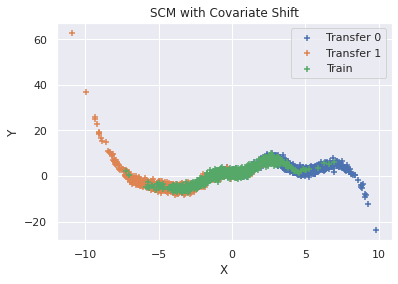

In [ ]:
SEED = 12345
torch.manual_seed(SEED)
np.random.seed(SEED)


scm = RandomSplineSCM(False, True, 8, 10, 3, range_scale=1.)

plt.figure()
plt.title("SCM with Covariate Shift")
scm.plot(X=normal(4, 2, 1000), show=False, label='Transfer 0')
scm.plot(X=normal(-4, 2, 1000), show=False, label='Transfer 1')
scm.plot(X=normal(0, 2, 1000), show=False, label='Train')
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.show()

0


1


2


3


4


5


6


7


8


9


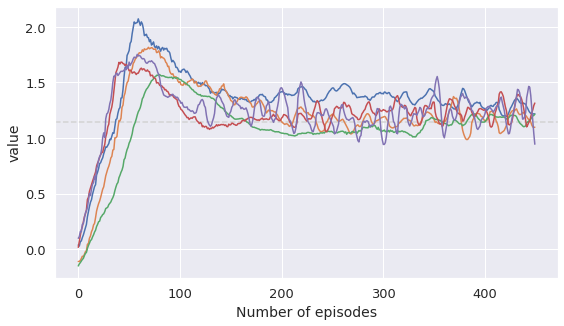

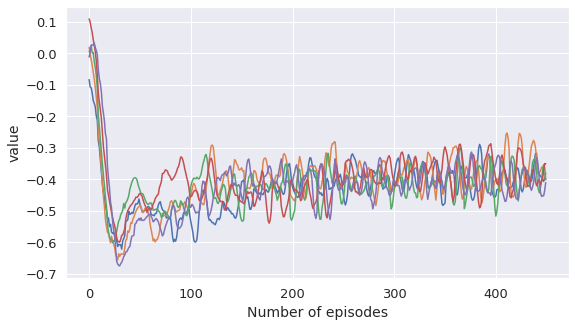

In [ ]:
import pandas as pd

causality_dir = 'normal'

SEED = 22
torch.manual_seed(SEED)
np.random.seed(SEED)

alphas_coll = []
mean_x2y_list = []
mean_y2x_list = []

x2y_actual_mean = np.mean([scm(torch.Tensor([[0]])).cpu().numpy()[0, 0] for i in range(10000)])

for i in range(10):
    print(i)
    model_x2y = mdn(opt)
    model_x2y_x = mdn_X_mu_sigma(opt)
    model_x2y_w = mdn_mu_sigma(opt)
    model_x2y_z = mdn_mu_sigma(opt)
    #print(model_x2y_x.mu, model_x2y_x.pi)
    frames_x2y = train_nll_new(opt, model_x2y, model_x2y_x, model_x2y_w, model_x2y_z, 
                              scm, opt.TRAIN_DISTRY, opt.DISTR_FOR_Z, opt.DISTR_FOR_W, 
                              polarity='X2Y', loss_fn=mdn_nll_new, causality_dir = causality_dir, get_means = True)
    #print(model_x2y_x.mu, model_x2y_x.pi)

    model_y2x = mdn(opt)
    model_y2x_x = mdn_X_mu_sigma(opt)
    model_y2x_w = mdn_mu_sigma(opt)
    model_y2x_z = mdn_mu_sigma(opt)
    frames_y2x = train_nll_new(opt, model_y2x, model_y2x_x, model_y2x_w, model_y2x_z, 
                              scm, opt.TRAIN_DISTRY, opt.DISTR_FOR_Z, opt.DISTR_FOR_W, 
                                polarity='Y2X', loss_fn=mdn_nll_new, causality_dir = causality_dir, get_means = True)

    mean_x2y = np.asarray([frame.mx for frame in frames_x2y])
    mean_y2x = np.asarray([frame.mx for frame in frames_y2x])

    mean_x2y_list.append(mean_x2y)
    mean_y2x_list.append(mean_y2x)


mean_x2y_df = pd.DataFrame({f'iteration {i+1}': mean_x2y_list[i] for i in range(5)})
mean_y2x_df = pd.DataFrame({f'iteration {i+1}': mean_y2x_list[i] for i in range(5)})

fig = plt.figure(figsize=(9, 5))
ax = plt.subplot(1, 1, 1)
ax.tick_params(axis='both', which='major', labelsize=13)
ax.axhline(x2y_actual_mean, c='lightgray', ls='--')
mean_x2y_df.plot(ax = ax, legend = False)
# ax.set_xlim([0, opt.ALPHA_NUM_ITER - 1])
ax.set_xlabel('Number of episodes', fontsize=14)
ax.set_ylabel('value', fontsize=14)
ax.legend(loc = 4, prop={'size': 13})
ax.legend().set_visible(False)
plt.show()


fig = plt.figure(figsize=(9, 5))
ax = plt.subplot(1, 1, 1)
ax.tick_params(axis='both', which='major', labelsize=13)
mean_y2x_df.plot(ax = ax, legend = False)
# ax.set_xlim([0, opt.ALPHA_NUM_ITER - 1])
ax.set_xlabel('Number of episodes', fontsize=14)
ax.set_ylabel('value', fontsize=14)
ax.legend(loc = 4, prop={'size': 13})
ax.legend().set_visible(False)
plt.show()

0


0.9579168558120728
1


0.23480994999408722
2


0.9532879590988159
3


0.985965371131897
4


0.9377227425575256
5


0.9790305495262146
6


0.8495463728904724
7


0.970321536064148
8


0.9848474860191345
9


0.9759735465049744


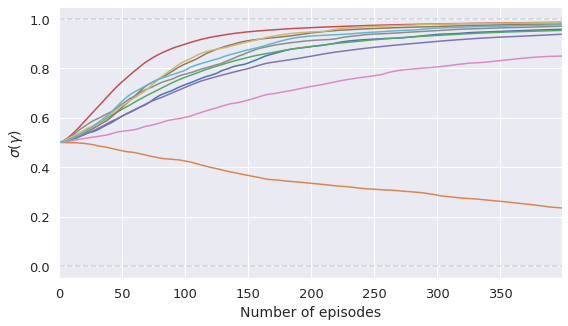

In [ ]:
import pandas as pd

causality_dir = 'normal'

SEED = 22
torch.manual_seed(SEED)
np.random.seed(SEED)

alphas_coll = []

for i in range(10):
    print(i)
    model_x2y = mdn(opt)
    model_x2y_x = mdn_X_mu_sigma(opt)
    model_x2y_w = mdn_mu_sigma(opt)
    model_x2y_z = mdn_mu_sigma(opt)
    #print(model_x2y_x.mu, model_x2y_x.pi)
    frames_x2y = train_nll_new(opt, model_x2y, model_x2y_x, model_x2y_w, model_x2y_z, 
                              scm, opt.TRAIN_DISTRY, opt.DISTR_FOR_Z, opt.DISTR_FOR_W, 
                              polarity='X2Y', loss_fn=mdn_nll_new, causality_dir = causality_dir)
    #print(model_x2y_x.mu, model_x2y_x.pi)

    model_y2x = mdn(opt)
    model_y2x_x = mdn_X_mu_sigma(opt)
    model_y2x_w = mdn_mu_sigma(opt)
    model_y2x_z = mdn_mu_sigma(opt)
    frames_y2x = train_nll_new(opt, model_y2x, model_y2x_x, model_y2x_w, model_y2x_z, 
                              scm, opt.TRAIN_DISTRY, opt.DISTR_FOR_Z, opt.DISTR_FOR_W, 
                                polarity='Y2X', loss_fn=mdn_nll_new, causality_dir = causality_dir)

    alpha = make_alpha(opt)
    alpha_frames = train_alpha_new(opt, model_x2y, model_x2y_x, model_x2y_w, model_x2y_z, 
                                  model_y2x, model_y2x_x, model_y2x_w, model_y2x_z, 
                                  alpha, scm, opt.PARAM_DISTRY, opt.PARAM_SAMPLER, 
                                  opt.DISTR_FOR_Z, opt.DISTR_FOR_W, 
                              mdn_nll_new, auc_transfer_metric_new, mixmode='logsigp', causality_dir = causality_dir)


    alphas = np.asarray([frame.sig_alpha for frame in alpha_frames])
    alphas_coll.append(alphas)
    print(alphas[-1])

alpha_df = pd.DataFrame({i: alphas_coll[i] for i in range(len(alphas_coll))})

fig = plt.figure(figsize=(9, 5))
ax = plt.subplot(1, 1, 1)

ax.tick_params(axis='both', which='major', labelsize=13)
ax.axhline(1, c='lightgray', ls='--')
ax.axhline(0, c='lightgray', ls='--')
alpha_df.plot(ax = ax, legend=False)

ax.set_xlim([0, opt.ALPHA_NUM_ITER - 1])
ax.set_xlabel('Number of episodes', fontsize=14)
ax.set_ylabel(r'$\sigma(\gamma)$', fontsize=14)
ax.legend(loc=4, prop={'size': 13})
ax.legend().set_visible(False)

plt.show()


0


1


2


3


4


5


6


7


8


9


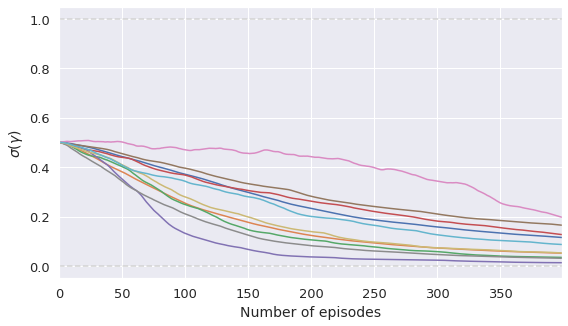

In [ ]:
import pandas as pd

causality_dir = 'reverse'

SEED = 22
torch.manual_seed(SEED)
np.random.seed(SEED)

alphas_coll = []

for i in range(10):
    print(i)
    model_x2y = mdn(opt)
    model_x2y_x = mdn_X_mu_sigma(opt)
    model_x2y_w = mdn_mu_sigma(opt)
    model_x2y_z = mdn_mu_sigma(opt)
    #print(model_x2y_x.mu, model_x2y_x.pi)
    frames_x2y = train_nll_new(opt, model_x2y, model_x2y_x, model_x2y_w, model_x2y_z, 
                              scm, opt.TRAIN_DISTRY, opt.DISTR_FOR_Z, opt.DISTR_FOR_W, 
                              polarity='X2Y', loss_fn=mdn_nll_new, causality_dir = causality_dir)
    #print(model_x2y_x.mu, model_x2y_x.pi)

    model_y2x = mdn(opt)
    model_y2x_x = mdn_X_mu_sigma(opt)
    model_y2x_w = mdn_mu_sigma(opt)
    model_y2x_z = mdn_mu_sigma(opt)
    frames_y2x = train_nll_new(opt, model_y2x, model_y2x_x, model_y2x_w, model_y2x_z, 
                              scm, opt.TRAIN_DISTRY, opt.DISTR_FOR_Z, opt.DISTR_FOR_W, 
                                polarity='Y2X', loss_fn=mdn_nll_new, causality_dir = causality_dir)

    alpha = make_alpha(opt)
    alpha_frames = train_alpha_new(opt, model_x2y, model_x2y_x, model_x2y_w, model_x2y_z, 
                                  model_y2x, model_y2x_x, model_y2x_w, model_y2x_z, 
                                  alpha, scm, opt.PARAM_DISTRY, opt.PARAM_SAMPLER, 
                                  opt.DISTR_FOR_Z, opt.DISTR_FOR_W, 
                              mdn_nll_new, auc_transfer_metric_new, mixmode='logsigp', causality_dir = causality_dir)


    alphas = np.asarray([frame.sig_alpha for frame in alpha_frames])
    alphas_coll.append(alphas)

alpha_df = pd.DataFrame({i: alphas_coll[i] for i in range(len(alphas_coll))})

fig = plt.figure(figsize=(9, 5))
ax = plt.subplot(1, 1, 1)

ax.tick_params(axis='both', which='major', labelsize=13)
ax.axhline(1, c='lightgray', ls='--')
ax.axhline(0, c='lightgray', ls='--')
alpha_df.plot(ax = ax, legend=False)

ax.set_xlim([0, opt.ALPHA_NUM_ITER - 1])
ax.set_xlabel('Number of episodes', fontsize=14)
ax.set_ylabel(r'$\sigma(\gamma)$', fontsize=14)
ax.legend(loc=4, prop={'size': 13})
ax.legend().set_visible(False)

plt.show()

0


1


2


3


4


5


6


7


8


9


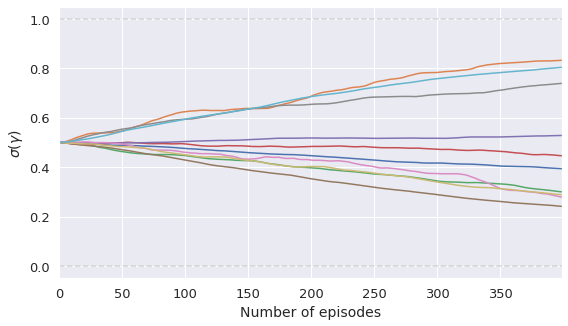

In [ ]:
import pandas as pd

causality_dir = 'none'

SEED = 22
torch.manual_seed(SEED)
np.random.seed(SEED)

alphas_coll = []

for i in range(10):
    print(i)
    model_x2y = mdn(opt)
    model_x2y_x = mdn_X_mu_sigma(opt)
    model_x2y_w = mdn_mu_sigma(opt)
    model_x2y_z = mdn_mu_sigma(opt)
    #print(model_x2y_x.mu, model_x2y_x.pi)
    frames_x2y = train_nll_new(opt, model_x2y, model_x2y_x, model_x2y_w, model_x2y_z, 
                              scm, opt.TRAIN_DISTRY, opt.DISTR_FOR_Z, opt.DISTR_FOR_W, 
                              polarity='X2Y', loss_fn=mdn_nll_new, causality_dir = causality_dir)
    #print(model_x2y_x.mu, model_x2y_x.pi)

    model_y2x = mdn(opt)
    model_y2x_x = mdn_X_mu_sigma(opt)
    model_y2x_w = mdn_mu_sigma(opt)
    model_y2x_z = mdn_mu_sigma(opt)
    frames_y2x = train_nll_new(opt, model_y2x, model_y2x_x, model_y2x_w, model_y2x_z, 
                              scm, opt.TRAIN_DISTRY, opt.DISTR_FOR_Z, opt.DISTR_FOR_W, 
                                polarity='Y2X', loss_fn=mdn_nll_new, causality_dir = causality_dir)

    alpha = make_alpha(opt)
    alpha_frames = train_alpha_new(opt, model_x2y, model_x2y_x, model_x2y_w, model_x2y_z, 
                                  model_y2x, model_y2x_x, model_y2x_w, model_y2x_z, 
                                  alpha, scm, opt.PARAM_DISTRY, opt.PARAM_SAMPLER, 
                                  opt.DISTR_FOR_Z, opt.DISTR_FOR_W, 
                              mdn_nll_new, auc_transfer_metric_new, mixmode='logsigp', causality_dir = causality_dir)


    alphas = np.asarray([frame.sig_alpha for frame in alpha_frames])
    alphas_coll.append(alphas)

alpha_df = pd.DataFrame({i: alphas_coll[i] for i in range(len(alphas_coll))})

fig = plt.figure(figsize=(9, 5))
ax = plt.subplot(1, 1, 1)

ax.tick_params(axis='both', which='major', labelsize=13)
ax.axhline(1, c='lightgray', ls='--')
ax.axhline(0, c='lightgray', ls='--')
alpha_df.plot(ax = ax, legend=False)

ax.set_xlim([0, opt.ALPHA_NUM_ITER - 1])
ax.set_xlabel('Number of episodes', fontsize=14)
ax.set_ylabel(r'$\sigma(\gamma)$', fontsize=14)
ax.legend(loc=4, prop={'size': 13})
ax.legend().set_visible(False)

plt.show()

0


0.2661933898925781
1


0.8399345874786377
2


0.04899725690484047
3


0.08985908329486847
4


0.9750087857246399
5


0.7887484431266785
6


0.07568878680467606
7


0.5564941763877869
8


0.9233989119529724
9


0.9333710670471191


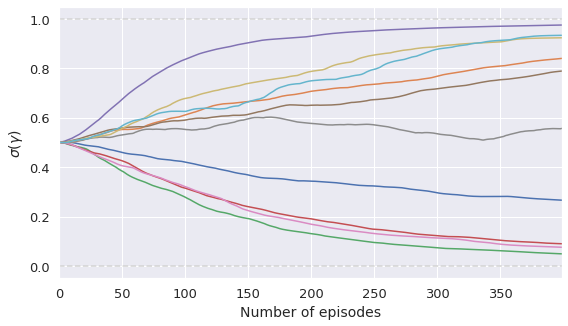

In [ ]:
import pandas as pd

causality_dir = 'normal'

SEED = 22
torch.manual_seed(SEED)
np.random.seed(SEED)

alphas_coll = []

for i in range(10):
    print(i)
    model_x2y = mdn(opt)
    model_x2y_x = mdn_X_mu_sigma(opt)
    model_x2y_w = mdn_mu_sigma(opt)
    model_x2y_z = mdn_mu_sigma(opt)
    #print(model_x2y_x.mu, model_x2y_x.pi)
    frames_x2y = train_nll_new(opt, model_x2y, model_x2y_x, model_x2y_w, model_x2y_z, 
                              scm, opt.TRAIN_DISTRY, opt.BETA_05_DISTR_FOR_Z, opt.DISTR_FOR_W, 
                              polarity='X2Y', loss_fn=mdn_nll_new, causality_dir = causality_dir)
    #print(model_x2y_x.mu, model_x2y_x.pi)

    model_y2x = mdn(opt)
    model_y2x_x = mdn_X_mu_sigma(opt)
    model_y2x_w = mdn_mu_sigma(opt)
    model_y2x_z = mdn_mu_sigma(opt)
    frames_y2x = train_nll_new(opt, model_y2x, model_y2x_x, model_y2x_w, model_y2x_z, 
                              scm, opt.TRAIN_DISTRY, opt.BETA_05_DISTR_FOR_Z, opt.DISTR_FOR_W, 
                                polarity='Y2X', loss_fn=mdn_nll_new, causality_dir = causality_dir)

    alpha = make_alpha(opt)
    alpha_frames = train_alpha_new(opt, model_x2y, model_x2y_x, model_x2y_w, model_x2y_z, 
                                  model_y2x, model_y2x_x, model_y2x_w, model_y2x_z, 
                                  alpha, scm, opt.PARAM_DISTRY, opt.PARAM_SAMPLER, 
                                  opt.BETA_05_DISTR_FOR_Z, opt.DISTR_FOR_W, 
                              mdn_nll_new, auc_transfer_metric_new, mixmode='logsigp', causality_dir = causality_dir)


    alphas = np.asarray([frame.sig_alpha for frame in alpha_frames])
    alphas_coll.append(alphas)
    print(alphas[-1])

alpha_df = pd.DataFrame({i: alphas_coll[i] for i in range(len(alphas_coll))})

fig = plt.figure(figsize=(9, 5))
ax = plt.subplot(1, 1, 1)

ax.tick_params(axis='both', which='major', labelsize=13)
ax.axhline(1, c='lightgray', ls='--')
ax.axhline(0, c='lightgray', ls='--')
alpha_df.plot(ax = ax, legend=False)

ax.set_xlim([0, opt.ALPHA_NUM_ITER - 1])
ax.set_xlabel('Number of episodes', fontsize=14)
ax.set_ylabel(r'$\sigma(\gamma)$', fontsize=14)
ax.legend(loc=4, prop={'size': 13})
ax.legend().set_visible(False)

plt.show()

In [ ]:
import pandas as pd

causality_dir = 'normal'

SEED = 22
torch.manual_seed(SEED)
np.random.seed(SEED)

alphas_coll = []

for i in range(10):
    print(i)
    model_x2y = mdn(opt)
    model_x2y_x = mdn_X_mu_sigma(opt)
    model_x2y_w = mdn_mu_sigma(opt)
    model_x2y_z = mdn_mu_sigma(opt)
    #print(model_x2y_x.mu, model_x2y_x.pi)
    frames_x2y = train_nll_new(opt, model_x2y, model_x2y_x, model_x2y_w, model_x2y_z, 
                              scm, opt.TRAIN_DISTRY, opt.BETA_3_DISTR_FOR_Z, opt.DISTR_FOR_W, 
                              polarity='X2Y', loss_fn=mdn_nll_new, causality_dir = causality_dir)
    #print(model_x2y_x.mu, model_x2y_x.pi)

    model_y2x = mdn(opt)
    model_y2x_x = mdn_X_mu_sigma(opt)
    model_y2x_w = mdn_mu_sigma(opt)
    model_y2x_z = mdn_mu_sigma(opt)
    frames_y2x = train_nll_new(opt, model_y2x, model_y2x_x, model_y2x_w, model_y2x_z, 
                              scm, opt.TRAIN_DISTRY, opt.BETA_3_DISTR_FOR_Z, opt.DISTR_FOR_W, 
                                polarity='Y2X', loss_fn=mdn_nll_new, causality_dir = causality_dir)

    alpha = make_alpha(opt)
    alpha_frames = train_alpha_new(opt, model_x2y, model_x2y_x, model_x2y_w, model_x2y_z, 
                                  model_y2x, model_y2x_x, model_y2x_w, model_y2x_z, 
                                  alpha, scm, opt.PARAM_DISTRY, opt.PARAM_SAMPLER, 
                                  opt.BETA_3_DISTR_FOR_Z, opt.DISTR_FOR_W, 
                              mdn_nll_new, auc_transfer_metric_new, mixmode='logsigp', causality_dir = causality_dir)


    alphas = np.asarray([frame.sig_alpha for frame in alpha_frames])
    alphas_coll.append(alphas)
    print(alphas[-1])

alpha_df = pd.DataFrame({i: alphas_coll[i] for i in range(len(alphas_coll))})

fig = plt.figure(figsize=(9, 5))
ax = plt.subplot(1, 1, 1)

ax.tick_params(axis='both', which='major', labelsize=13)
ax.axhline(1, c='lightgray', ls='--')
ax.axhline(0, c='lightgray', ls='--')
alpha_df.plot(ax = ax, legend=False)

ax.set_xlim([0, opt.ALPHA_NUM_ITER - 1])
ax.set_xlabel('Number of episodes', fontsize=14)
ax.set_ylabel(r'$\sigma(\gamma)$', fontsize=14)
ax.legend(loc=4, prop={'size': 13})
ax.legend().set_visible(False)

plt.show()

In [ ]:
import pandas as pd

SEED = 1234
torch.manual_seed(SEED)
np.random.seed(SEED)

causality_dir = 'normal'

totals = [1000, 1000, 1000, 100, 100, 100, 30, 30, 30]
totals_transfer = [500, 500, 500, 50, 50, 50, 15, 15, 15]
n_samples = [200, 200, 200, 50, 50, 50, 15, 15, 15]
nr_transfers = [10, 3, 1, 10, 3, 1, 10, 3, 1]

alpha_res_mean = []
alpha_res_med = []
alpha_res_std = []

for i in range(9):
  print(i)
  inner_alphas = []
  for j in range(10):
    print(j)
    opt.NUM_SAMPLES = n_samples[i]
    opt.NUM_SAMPLES_TOTAL = totals[i]
    opt.NUM_TRANSFER_SAMPLES_TOTAL = totals_transfer[i]
    opt.NUM_TRANSFER_DISTRS = nr_transfers[i]

    Zs_train, Ws_train, Xs_train, Ys_train, Zs_transfer, Ws_transfer, Xs_transfer, Ys_transfer = var_gen(opt, scm)

    model_x2y = mdn(opt)
    model_x2y_x = mdn_X_mu_sigma(opt)
    model_x2y_w = mdn_mu_sigma(opt)
    model_x2y_z = mdn_mu_sigma(opt)
    #print(model_x2y_x.mu, model_x2y_x.pi)
    frames_x2y = train_nll_new(opt, model_x2y, model_x2y_x, model_x2y_w, model_x2y_z, 
                              scm, opt.TRAIN_DISTRY, opt.DISTR_FOR_Z, opt.DISTR_FOR_W, 
                              polarity='X2Y', loss_fn=mdn_nll_new, causality_dir = causality_dir,
                              Xs = Xs_train, Ys = Ys_train, Ws = Ws_train, Zs = Zs_train, passed_rds = True)
    #print(model_x2y_x.mu, model_x2y_x.pi)

    model_y2x = mdn(opt)
    model_y2x_x = mdn_X_mu_sigma(opt)
    model_y2x_w = mdn_mu_sigma(opt)
    model_y2x_z = mdn_mu_sigma(opt)
    frames_y2x = train_nll_new(opt, model_y2x, model_y2x_x, model_y2x_w, model_y2x_z, 
                              scm, opt.TRAIN_DISTRY, opt.DISTR_FOR_Z, opt.DISTR_FOR_W, 
                                polarity='Y2X', loss_fn=mdn_nll_new, causality_dir = causality_dir, 
                              Xs = Xs_train, Ys = Ys_train, Ws = Ws_train, Zs = Zs_train, passed_rds = True)

    alpha = make_alpha(opt)
    alpha_frames = train_alpha_new(opt, model_x2y, model_x2y_x, model_x2y_w, model_x2y_z, 
                                  model_y2x, model_y2x_x, model_y2x_w, model_y2x_z, 
                                  alpha, scm, opt.PARAM_DISTRY, opt.PARAM_SAMPLER, 
                                  opt.DISTR_FOR_Z, opt.DISTR_FOR_W, 
                              mdn_nll_new, auc_transfer_metric_new, mixmode='logsigp', causality_dir = causality_dir, 
                              Xs = Xs_transfer, Ys = Ys_transfer, Ws = Ws_transfer, Zs = Zs_transfer, passed_rds = True)



    alphas = np.asarray([frame.sig_alpha for frame in alpha_frames])

    inner_alphas.append(alphas[-1])
  print(len(inner_alphas), inner_alphas[-1])
    
  alpha_res_mean.append(np.mean(inner_alphas))
  alpha_res_med.append(np.median(inner_alphas))
  alpha_res_std.append(np.std(inner_alphas))

  print(len(alpha_res_mean))


res_df = pd.DataFrame({'samples drawn': n_samples, 'training samples': totals, 'transfer samples': totals_transfer, 'transfer distributions': nr_transfers,
                       'alpha mean': alpha_res_mean, 'alpha median': alpha_res_med, 'alpha std': alpha_res_std})
res_df

0
0


1


2


3


4


5


6


7


8


9


10 0.9994974136352539
1
1
0


1


2


3


4


5


6


7


8


9


10 0.8719158172607422
2
2
0


1


2


3


4


5


6


7


8


9


10 0.2658844590187073
3
3
0


1


2


3


4


5


6


7


8


9


10 0.9996090531349182
4
4
0


1


2


3


4


5


6


7


8


9


10 0.9999420642852783
5
5
0


1


2


3


4


5


6


7


8


9


10 0.9979179501533508
6
6
0


1


2


3


4


5


6


7


8


9


10 0.014313329942524433
7
7
0


1


2


3


4


5


6


7


8


9


10 0.9992547631263733
8
8
0


1


2


3


4


5


6


7


8


9


10 1.0
9
9
0


1


2


3


4


5


6


7


8


9


10 0.9999990463256836
10
10
0


1


2


3


4


5


6


7


8


9


10 2.042453843387193e-06
11
11
0


1


2


3


4


5


6


7


8


9


10 4.502283458330842e-16
12


samples drawn  training samples  ...  alpha median  alpha std
0             200              1000  ...      0.998471   0.008770
1             200              1000  ...      0.977434   0.306113
2             200              1000  ...      0.974540   0.235137
3             150               500  ...      0.995763   0.297141
4             150               500  ...      0.982288   0.396785
5             150               500  ...      0.994780   0.298422
6              50               100  ...      0.999856   0.294733
7              50               100  ...      0.999578   0.395468
8              50               100  ...      1.000000   0.396126
9              15                30  ...      0.000016   0.458252
10             15                30  ...      0.500070   0.499956
11             15                30  ...      0.499983   0.499993

[12 rows x 7 columns]

In [ ]:
res_df

samples drawn  training samples  ...  alpha median  alpha std
0             200              1000  ...      0.998471   0.008770
1             200              1000  ...      0.977434   0.306113
2             200              1000  ...      0.974540   0.235137
3             150               500  ...      0.995763   0.297141
4             150               500  ...      0.982288   0.396785
5             150               500  ...      0.994780   0.298422
6              50               100  ...      0.999856   0.294733
7              50               100  ...      0.999578   0.395468
8              50               100  ...      1.000000   0.396126
9              15                30  ...      0.000016   0.458252
10             15                30  ...      0.500070   0.499956
11             15                30  ...      0.499983   0.499993

[12 rows x 7 columns]

In [ ]:
# END OF THE COLAB